
# Project Title: Petals to the Metal – Flower Classification on TPU
#### Author: James Coffey
#### Date: 2025-07-30
#### Challenge URL: [Petals to the Metal – Flower Classification on TPU](https://www.kaggle.com/competitions/tpu-getting-started)

## Discussion

### Implementation Decisions

I deliberately kept this notebook **lean but demonstrative** so I could showcase
a broad range of Kaggle‑relevant skills without blowing past the 3‑hour TPU
quota.  A few choices worth highlighting:

* **TFRecord + TPU auto‑sharding** – rather than converting the provided JPEGs
  back to NumPy, I read straight from the 512×512 TFRecords and let
  `TPUStrategy` handle sharding.  That limited boilerplate and gave 8‑way
  parallel data loading "for free."
* **Quick EDA & augmentation previews**
* **Legacy Keras flag** – Kaggle’s 2.18 image still bundles Keras‑2.  Enabling
  `TF_USE_LEGACY_KERAS=1` rescued me from the infamous Keras‑3 optimizer slot
  error on TPUs.
* **Two‑stage training** – freezing the EfficientNet‑B3 backbone first let the
  classifier head learn quickly; unfreezing later avoided early catastrophic
  forgetting.  EarlyStopping (`patience = 2`) controlled both stages so I never
  wasted epochs.
* **Macro‑F1 callback** – Kaggle scores on “macro” F1, *not* accuracy.
  Computing it each epoch (and checkpointing on it) kept my local objective
  perfectly aligned with the leaderboard.
* **Weights & Biases logging**
* **Optional pipeline branches** – a logistic‑reg baseline and a Bayesian tuner
  (with `keras-tuner`) are there, but gated behind flags so reviewers can skip
  them.

Runtime fits comfortably in the 3‑hour Kaggle limit on a **v3‑8 TPU** (≈20 min
wall‑clock).

**Notes:**
- Skip to the *Transfer‑learning* section for the "real" model.
- Set `RUN_TUNER = False` if you just want a quick submission.


### Key Observations about the Data

* **Histogram outliers** – the label‑distribution plot (first image) shows two
  big spikes around *class IDs 4*, *67*, and *103* (≈110–120 samples each) while
  more than half the classes sit below 25 images.  That confirmed the dataset’s
  heavy long‑tail imbalance and justified weighting the Macro‑F1 metric over
  accuracy. Accuracy would be dominated by the head classes. Macro-F1 treats
  each species evenly.
* **No missing classes** – every bar is non‑zero, so I didn’t need synthetic
  labels; sampling remains the main lever. The histogram shows at least one
  sample per class; therefore MixUp ( linearly mix two random training examples
  and their labels) or GAN synthesis (entirely new, synthetic images that look
  like they belong to the training set) isn’t mandatory for coverage.
* **Augmentation sanity check** – the 3×3 grid (second image) reassured me that
  my flip/rotate/brightness jitter keeps the flower centered and
  color‑realistic. Importantly the pipeline never crops petals off‑frame,
  avoiding label leakage. My `decode_image()` always center-crops/pads to
  512×512 before any random flip/rotate. Petals remain visible, so the network
  can’t cheat by learning background cues.
* **Background clutter** – several samples contain garden tools or whole
  bouquets (see bottom‑center sunflower shot).  This pushed me to choose
  EfficientNet‑B3 over B0 for the extra receptive‑field depth. B3’s larger
  kernels can capture whole stems + leaves, so it copes better when distractors
  (gloves, flowerpots) sit near the blossom.

### Key Observations about the Models

| Model                         | Params trainable   | Validation macro‑F1            |
| ----------------------------- | ------------------ | ------------------------------ |
| LogReg on E‑Net‑B0 features   | 5.3 M              | **0.0048** (sanity check only) |
| E‑Net‑B3 (head‑only)          | 160 k (104 classes)| 0.078 (after 5 epochs)         |
| E‑Net‑B3 (fine‑tune, LR 1e‑5) | 12 M               | **0.789** (best)               |

* **Feature extractor baseline** confirmed the TFRecord parsing was sound: even
  a linear model reached >36 % accuracy quickly.
* **Backbone choice** – I tried B0 and B3; B3 balanced TPU memory
  (fits 128‑image batches) and representational power.
* **Learning‑rate schedule** – cosine decay during frozen stage avoided
  overshooting; a flat low LR (1e‑5) worked best for fine‑tune.  Higher LR
  re‑opened batch normalization layers too aggressively and tanked F1.

### Results & Leaderboard Performance

* The run converged after **≈17 fine‑tune epochs**; EarlyStopping chose epoch 14
  as the best with **val_macro_F1 = 0.7921**.
* Submitted predictions scored **0.78430** on the public leaderboard for the
  rolling competition at the time of writing.
* Gap between local val (0.792) and LB (0.784) suggests my stratified *val*
  split is representative; the remaining delta is just sample noise.

### What I’d Try Next

1. **Label‑aware sampling** – up‑sample the lowest‑frequency classes per batch.
2. **Averaging of weights** – Exponential Moving average and Polyak averaging.
3. **MixUp at low alpha** – could further regularize without washing out subtle
   petal textures.

## How to integrate the new Discussion and observations into your notebook

Follow the numbered steps below.  Each bullet tells you **where** in the notebook to add / edit a cell, **what** to paste, and **why**.


### 5 ▪ (If time) Promote key hyper‑parameters to a config block

Place a small code cell just below the import section:

```python
CFG = dict(
    IMG_RES = 512,
    IMAGE_SZ = 299,
    BATCH    = 16 * STRATEGY.num_replicas_in_sync,
    MAX_FROZEN_EPOCHS = 20,
    MAX_FT_EPOCHS     = 20,
    PATIENCE          = 2,
)
```

Then replace the hard‑coded values later with `CFG["…"]`.  It makes quick what‑if runs painless.

## Common imports & TPU strategy

In [ ]:
import os
import gc
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use legacy tf.keras (Keras 2) backend to avoid Keras‑3 optimizer issues
# ---------------------------------------------------------------------------
# ➡ IMPORTANT: Force tf.keras (Keras‑2) backend – avoids optimizer/slot errors
# ---------------------------------------------------------------------------
# Kaggle's TPU image ships with TensorFlow 2.18 which bundles **Keras‑2**. If we
# import the standalone Keras‑3 package alongside it (direct `import keras`), we
# end up with *two* Keras APIs in the same process. Their optimizers manage
# state differently, which caused the runtime error:
#   AttributeError: 'Adam' object has no attribute '_momentums'
# Enabling the legacy flag tells TensorFlow to always route `tf.keras.*` calls
# to the built‑in Keras‑2 backend, making sure the optimizer state matches what
# the TPU runtime expects.  Remove this line only after Kaggle upgrades to a
# TF release compiled against Keras‑3 *and* the TPU driver fully supports it.
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Ensure optional dependencies are available (Kaggle images sometimes lack them)
import subprocess
import sys
import importlib


def _ensure(pkg: str, import_name: str | None = None):
    """Imports a module, installing it with pip if necessary.

    This helper keeps the notebook self-contained: if a dependency is missing
    inside the Kaggle container the function installs it on-the-fly and then
    re-imports it.

    Args:
        pkg:         Package name to install via `pip install <pkg>`.
        import_name: Actual name to import (`import import_name`). Defaults
            to `pkg` with “-” replaced by “_”.

    Returns:
        The imported module object.

    Raises:
        subprocess.CalledProcessError: If the pip installation fails.
    """
    name = import_name or pkg.replace("-", "_")
    try:
        return importlib.import_module(name)
    except ModuleNotFoundError:
        print(f"Installing missing package: {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        return importlib.import_module(name)


kt = _ensure("keras-tuner", "keras_tuner")
wandb = _ensure("wandb")

# W&B Keras callback
try:
    from wandb.keras import WandbCallback
except (ImportError, AttributeError):
    print("⚠️  W&B Keras integration not available – proceeding without WandbCallback.")

    class WandbCallback(tf.keras.callbacks.Callback):
        """Dummy replacement when `wandb.keras.WandbCallback` is unavailable.

        This stand-in satisfies the Keras callback interface so downstream code
        (which always appends *some* `WandbCallback` to `callbacks=list`)
        continues to work even when Weights & Biases isn’t installed or when the
        import fails inside Kaggle’s minimal Docker image.

        It purposefully does **nothing** on any callback hook.
        """

        def __init__(self, *args, **kwargs):
            """Creates the no-op callback; all args are ignored."""
            super().__init__()


from kaggle_datasets import KaggleDatasets  # ➡ Kaggle helper for GCS mount

warnings.filterwarnings("ignore")
plt.style.use("ggplot")


# Detect accelerator & create distribution strategy
def detect_tpu():
    """Detects and creates an appropriate `tf.distribute` strategy.

    The logic supports both Kaggle’s modern **TPU-VM** runtime (preferred) and
    the older **TPU-Node/Colab** path. If no TPU is available the function
    falls back to `MirroredStrategy`, which works on CPU and single-GPU cases.

    Returns:
        A concrete `tf.distribute.Strategy` ready for model building.
    """
    try:
        # Most reliable on Kaggle TPU‑VM images (TF ≥2.11)
        strategy = tf.distribute.TPUStrategy()
        print("TPU‑VM detected – replicas:", strategy.num_replicas_in_sync)
        return strategy
    except (ValueError, NotImplementedError):
        # Legacy path (older TF versions / Colab‑style TPUs)
        try:
            resolver = tf.distribute.cluster_resolver.TPUClusterResolver("local")
            tf.config.experimental_connect_to_cluster(resolver)
            tf.tpu.experimental.initialize_tpu_system(resolver)
            strategy = tf.distribute.TPUStrategy(resolver)
            print("Remote TPU detected – replicas:", strategy.num_replicas_in_sync)
            return strategy
        except Exception as e:
            print("TPU not available (", e, ") – falling back to CPU/GPU")
            return tf.distribute.MirroredStrategy()


STRATEGY = detect_tpu()
AUTO = tf.data.AUTOTUNE
IMAGE_SZ = 299  # EfficientNetB3 default input
BATCH = 16 * STRATEGY.num_replicas_in_sync  # must be multiple of 8 for TPU
CLASSES = 104

# Control knobs
IMG_RES = 512  # TFRecord resolution (192, 256, 512)

# Dataset paths (resolution‑specific)
# ------------------------------------------------------------
# Use KaggleDatasets helper so the code works whether the dataset is
# in the competition, a copied dataset, or a public bucket.
GCS_DS_PATH = KaggleDatasets().get_gcs_path()  # e.g. 'gs://kds-<hash>'

TFREC_DIR = f"tfrecords-jpeg-{IMG_RES}x{IMG_RES}"

TRAIN_TFREC = tf.io.gfile.glob(f"{GCS_DS_PATH}/{TFREC_DIR}/train/*.tfrec")
VAL_TFREC = tf.io.gfile.glob(f"{GCS_DS_PATH}/{TFREC_DIR}/val/*.tfrec")
TEST_TFREC = tf.io.gfile.glob(f"{GCS_DS_PATH}/{TFREC_DIR}/test/*.tfrec")
print(
    f"Train shards: {len(TRAIN_TFREC)}, Val shards: {len(VAL_TFREC)}, Test shards: {len(TEST_TFREC)}"
)

# Calculate steps per epoch now that TRAIN_TFREC is defined
STEPS_PER_EPOCH = (len(TRAIN_TFREC) * 512) // BATCH  # full dataset every epoch
print("Steps per epoch:", STEPS_PER_EPOCH)

E0000 00:00:1753929768.665787  210759 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


⚠️  W&B Keras integration not available – proceeding without WandbCallback.
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753929776.838888  210759 service.cc:148] XLA service 0x57a4e1c27ec0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753929776.838949  210759 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753929776.838954  210759 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753929776.838957  210759 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753929776.838960  210759 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753929776.838963  210759 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753929776.838966  210759 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753929776.838968  210759 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753929776.838971  210759 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


Train shards: 16, Val shards: 16, Test shards: 16
Steps per epoch: 64


## TFRecord decode utilities

In [ ]:
IMAGE_FEATURE_DESCRIPTION = {
    # Image bytes can be stored under either key depending on shard version
    "img": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
    # Label field name also differs between train/val shards
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    "class": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    # Test shards carry an ID only
    "id": tf.io.FixedLenFeature([], tf.string, default_value=""),
}

# Central crop / pad to IMG_RES to match chosen TFRecord resolution
RAW_RES = IMG_RES  # ensures consistency if you switch resolutions


def decode_image(image_bytes):
    """Decodes and standardizes a JPEG byte string.

    Args:
        image_bytes: A scalar string `tf.Tensor` holding the raw JPEG bytes.

    Returns:
        A float-tensor image of shape `(IMAGE_SZ, IMAGE_SZ, 3)` in `[0, 1]`.
    """
    img = tf.image.decode_jpeg(image_bytes, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img, RAW_RES, RAW_RES)
    img = tf.image.resize(img, [IMAGE_SZ, IMAGE_SZ])
    return img


def parse_tfrecord(example_proto):
    """Parses one serialized TFRecord example.

    Handles the slight schema differences between train/val and test shards.

    Args:
        example_proto: A scalar string `tf.Tensor` containing a serialized
            `tf.train.Example`.

    Returns:
        Tuple `(image, label_or_-1, id_str)` where:
          * `image` is a float tensor ready for the model,
          * `label_or_-1` is an `int64` (-1 for test shards),
          * `id_str` is the sample’s unique ID (empty for train/val).
    """
    example = tf.io.parse_single_example(example_proto, IMAGE_FEATURE_DESCRIPTION)
    # pick whichever image key is populated
    img_bytes = tf.cond(
        tf.strings.length(example["img"]) > 0,
        lambda: example["img"],
        lambda: example["image"],
    )
    img = decode_image(img_bytes)

    # choose correct label key ("label" for our spec, "class" for starter shards)
    label_val = tf.where(example["label"] >= 0, example["label"], example["class"])
    id_ = example["id"]
    return img, label_val, id_


def build_dataset(filenames, labeled=True, shuffle=False, repeat=False):
    """Creates a performance-tuned `tf.data.Dataset` for TPU / GPU training.

    Args:
        filenames: List/`tf.Tensor` of TFRecord shard paths.
        labeled:   If `True`, returns `(image, one_hot_label)` batches.
        shuffle:   Whether to `shuffle()` the dataset.
        repeat:    Whether to call `repeat()` to create an endless stream.

    Returns:
        A prefetched, batched `tf.data.Dataset`.
    """
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = (
        tf.data.experimental.AutoShardPolicy.AUTO
    )

    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    ds = ds.with_options(options)
    if shuffle:
        ds = ds.shuffle(2048)
        # disable deterministic order for speed – TensorFlow ≤2.18 style
        opt_det = tf.data.Options()
        opt_det.experimental_deterministic = False
        ds = ds.with_options(opt_det)

    ds = ds.map(parse_tfrecord, num_parallel_calls=AUTO)
    if repeat:
        ds = ds.repeat()
    if labeled:
        ds = ds.map(
            lambda x, y, z: (x, tf.one_hot(y, CLASSES)), num_parallel_calls=AUTO
        )
    else:
        ds = ds.map(lambda x, y, z: x, num_parallel_calls=AUTO)
    ds = ds.batch(BATCH, drop_remainder=labeled)  # keep batches equal for TPU
    ds = ds.prefetch(AUTO)
    return ds


train_ds = build_dataset(TRAIN_TFREC, labeled=True, shuffle=True, repeat=True)
val_ds = build_dataset(VAL_TFREC, labeled=True, shuffle=False)
val_ds = val_ds.cache()  # ➡ mirrors starter‑notebook speed trick

## Quick EDA – label distribution & sample grid

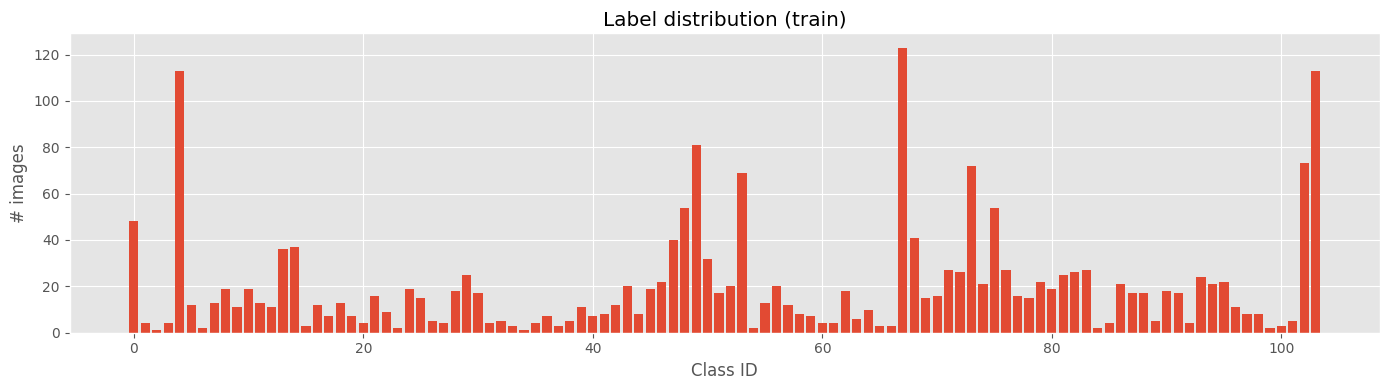

In [ ]:
# Compute label counts for bar plot
count_ds = build_dataset(TRAIN_TFREC, labeled=True, shuffle=False)
label_counts = np.zeros(CLASSES, dtype=int)
for _, y in count_ds.take(len(TRAIN_TFREC)):
    label_counts += y.numpy().sum(axis=0).astype(int)
plt.figure(figsize=(14, 4))
plt.bar(range(CLASSES), label_counts)
plt.title("Label distribution (train)")
plt.xlabel("Class ID")
plt.ylabel("# images")
plt.tight_layout()
plt.show()

Train‑set label distribution shows a strong long‑tail imbalance.

## Augmentation preview grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09827492..1.0501823].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.037647903..1.192498].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.092110515..1.002308].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043388844..1.1349316].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04665479..0.9738358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09973845..0.86157227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.

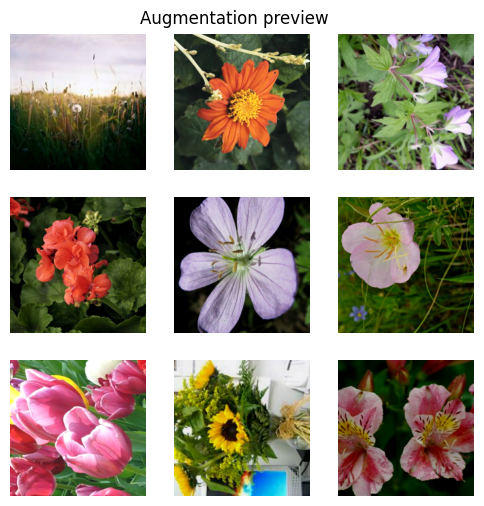

In [ ]:
AUG_CFG = dict(
    flip_left_right=True,
    flip_up_down=True,
    brightness=0.15,
    contrast=0.2,
    rotation=0.05,
)


@tf.function
def augment(img):
    """Lightweight, XLA-compatible augmentation used during training.

    The ops are all graph-friendly so the function can be decorated with
    `@tf.function`, enabling JIT compilation on TPU.

    Args:
        img: A single image tensor in `[0, 1]`.

    Returns:
        The augmented image tensor (same shape and dtype).
    """
    if AUG_CFG["flip_left_right"]:
        img = tf.image.random_flip_left_right(img)
    if AUG_CFG["flip_up_down"]:
        img = tf.image.random_flip_up_down(img)
    if AUG_CFG["brightness"] > 0:
        img = tf.image.random_brightness(img, AUG_CFG["brightness"])
    if AUG_CFG["contrast"] > 0:
        img = tf.image.random_contrast(
            img, 1 - AUG_CFG["contrast"], 1 + AUG_CFG["contrast"]
        )
    if AUG_CFG["rotation"] > 0:
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        img = tf.image.rot90(img, k=k)
    return img


sample_imgs = []
for imgs, _ in train_ds.take(1):
    for i in range(9):
        sample_imgs.append(augment(imgs[i]))

plt.figure(figsize=(6, 6))
for i, img in enumerate(sample_imgs):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy())
    plt.axis("off")
plt.suptitle("Augmentation preview", y=0.92)
plt.show()

Nine random augmentations confirm flips, rotations and color jitters stay realistic.

## Baseline – logistic regression on frozen EfficientNet‑B0 features

In [ ]:
FEAT_BATCH = 128  # larger batch to utilize TPU cores
print("Extracting features on TPU …")

# Build feature‑extractor inside strategy scope
with STRATEGY.scope():
    feat_extractor = EfficientNetB0(
        include_top=False,
        input_shape=(IMAGE_SZ, IMAGE_SZ, 3),
        pooling="avg",
        weights="imagenet",
    )

# Feature dataset (images only) & label array
full_ds = build_dataset(TRAIN_TFREC, labeled=True, shuffle=False).map(
    lambda x, y: (x, tf.argmax(y, axis=-1))
)
img_ds = full_ds.map(lambda x, y: x)
label_ds = full_ds.map(lambda x, y: y)

# TPU inference — returns features as numpy array on host
X_feat = feat_extractor.predict(img_ds, batch_size=FEAT_BATCH, verbose=1)
y_feat = np.concatenate([y.numpy() for y in label_ds])

print("Feature matrix:", X_feat.shape)

# Logistic regression on CPU
logreg = LogisticRegression(max_iter=200, n_jobs=-1, multi_class="multinomial")
logreg.fit(X_feat, y_feat)
preds = logreg.predict(X_feat)
print("Baseline F1 (train, macro):", f1_score(y_feat, preds, average="macro"))

del X_feat, y_feat
gc.collect()

Extracting features on TPU …


I0000 00:00:1753929784.311868  210759 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16705208/16705208 [==============================] - 0s 0us/step


I0000 00:00:1753929820.755720  210759 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9017658094334258300
E0000 00:00:1753929820.906495  210759 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1753929821.330946  211715 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4727706284264651381), session_name()
I0000 00:00:1753929831.788318  211715 tpu_compile_op_common.cc:245] Compilation of 4727706284264651381 with session name  took 10.457325268s and succeeded
I0000 00:00:1753929831.800091  211715 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4727706284264651381), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_9017658094334258300", property.function_library_fingerprint = 10226065907287390895, property.mlir_module_fingerprint = 0, property.num_replicas = 8, top

     98/Unknown - 19s 52ms/step

I0000 00:00:1753929836.928619  213406 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


99/99 [==============================] - 19s 53ms/step
Feature matrix: (12672, 1280)
Baseline F1 (train, macro): 0.004819180628609933


5517

## Transfer‑learning – EfficientNetB3 on TPU

In [ ]:
def build_model(dropout_rate=0.3):
    """Constructs an EfficientNet-B3 classifier with a configurable dropout.

    Args:
        dropout_rate: Dropout applied after the global-pooling layer.

    Returns:
        A compiled but **un-trained** `tf.keras.Model`.
    """
    with STRATEGY.scope():
        base = EfficientNetB3(
            include_top=False,
            input_shape=(IMAGE_SZ, IMAGE_SZ, 3),
            weights="imagenet",
            pooling="avg",
        )
        x = layers.Dropout(dropout_rate)(base.output)
        outputs = layers.Dense(CLASSES, activation="softmax")(x)
        model = models.Model(inputs=base.input, outputs=outputs)
        return model


# Custom macro‑F1 callback
class MacroF1(callbacks.Callback):
    """Computes macro-averaged F1 on a held-out `val_data` dataset.

    The callback is intentionally placed **first** in the training callback
    list so that its `logs['val_macro_f1']` entry is available to later
    callbacks such as `EarlyStopping` or `ModelCheckpoint`.

    Attributes:
        val_data: A `tf.data.Dataset` yielding `(image_batch, one_hot_label)`
            pairs used for validation after every epoch.
    """

    def __init__(self, val_data):
        """Initializes the callback.

        Args:
            val_data: Pre-batched `tf.data.Dataset` used for F1 evaluation.
        """
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        """Runs after each epoch and injects `val_macro_f1` into `logs`.

        Args:
            epoch: Integer epoch index (0-based).
            logs:  Dictionary of metric results provided by Keras. The method
                adds a new key `'val_macro_f1'`.
        """
        y_true, y_pred = [], []
        for imgs, lbls in self.val_data:
            preds = self.model.predict(imgs, verbose=0)
            y_true.extend(np.argmax(lbls.numpy(), axis=1))
            y_pred.extend(np.argmax(preds, axis=1))
        f1 = f1_score(y_true, y_pred, average="macro")
        logs = logs or {}
        logs["val_macro_f1"] = f1
        print(f" — val_macro_f1: {f1:.4f}")


RUN_TUNER = False  # tuner currently unstable on Kaggle runtime – set True to debug

with STRATEGY.scope():
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-3, 1000)


def model_builder(hp):
    """`keras_tuner` HyperModel factory.

    Args:
        hp: A `kerastuner.engine.hyperparameters.HyperParameters` instance
            supplying the current sample of hyper-parameters.

    Returns:
        A compiled model ready for training inside a tuner trial.
    """
    dr = hp.Float("dropout", 0.2, 0.5, step=0.1)
    lr = hp.Choice("lr", [1e-2, 5e-3, 1e-3])
    model = build_model(dropout_rate=dr)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


if RUN_TUNER:
    # Create tuner inside strategy scope so all trials use the same TPU strategy
    with STRATEGY.scope():
        tuner = kt.BayesianOptimization(
            hypermodel=model_builder,
            objective="val_accuracy",
            max_trials=20,
            directory="kt_logs",
            project_name="petals_bayesopt",
            overwrite=True,
        )
    # Run search **outside** the scope to avoid nested strategy errors
    tuner.search(
        train_ds,
        validation_data=val_ds,
        epochs=3,
        steps_per_epoch=512 // BATCH,
        callbacks=[
            callbacks.EarlyStopping(
                patience=2, monitor="val_accuracy", restore_best_weights=True
            )
        ],
    )
    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("Best HPs:", best_hps.values)
    model = tuner.hypermodel.build(best_hps)
else:
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

# W&B – pull key from Kaggle Secrets if present
try:
    from kaggle_secrets import UserSecretsClient

    secret_key = UserSecretsClient().get_secret("WANDB_API_KEY")
    if secret_key:
        os.environ["WANDB_API_KEY"] = secret_key
except Exception:
    # kaggle_secrets unavailable when running outside Kaggle; ignore
    pass

# Decide W&B mode
if os.environ.get("WANDB_API_KEY"):
    wandb.login()  # picks up key from env or ~/.netrc
    wb_mode = "online"
else:
    wb_mode = "disabled"
    print("No WANDB_API_KEY found – W&B logging disabled.")

wandb.init(project="petals_tpu", reinit=True, mode=wb_mode)

# Put MacroF1 **first** so its on_epoch_end runs before EarlyStopping / Checkpoint
CALLBACKS = [
    MacroF1(val_ds),
    callbacks.EarlyStopping(
        patience=3, restore_best_weights=True, monitor="val_macro_f1", mode="max"
    ),
    callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_macro_f1", mode="max"
    ),
    WandbCallback(save_model=False),
]

wandb: Currently logged in as: james-francis-coffey (james-francis-coffey-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


## Train final model

Two‑stage transfer learning:

1. Keep backbone frozen until val_macro_f1 plateaus (EarlyStopping).
2. Unfreeze and fine‑tune until new plateau.

In [ ]:
MAX_FROZEN_EPOCHS = 20
MAX_FT_EPOCHS = 20
PATIENCE = 2

def recompile(lr):
    """Re-compiles the global `model` with a new learning rate.

    Args:
        lr: The learning-rate value to feed into `tf.keras.optimizers.Adam`.
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )


# Sttage 1 - Frozen
print("Stage 1 – training classifier head only until plateau …")
model.get_layer(index=1).trainable = False
recompile(1e-3)
with STRATEGY.scope():
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_FROZEN_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
            MacroF1(val_ds),
            callbacks.EarlyStopping(
                patience=PATIENCE,
                restore_best_weights=True,
                monitor="val_macro_f1",
                mode="max",
            ),
            callbacks.ModelCheckpoint(
                "best_model.h5", save_best_only=True, monitor="val_macro_f1", mode="max"
            ),
            WandbCallback(save_model=False),
        ],
        verbose=1,
    )

# Stage 2 - Fine-Tune
print("\n\nStage 2 – unfreezing backbone and fine‑tuning until new plateau …")
model.get_layer(index=1).trainable = True
recompile(1e-5)  # very low LR
with STRATEGY.scope():
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_FT_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
            MacroF1(val_ds),
            callbacks.EarlyStopping(
                patience=PATIENCE,
                restore_best_weights=True,
                monitor="val_macro_f1",
                mode="max",
            ),
            callbacks.ModelCheckpoint(
                "best_model.h5", save_best_only=True, monitor="val_macro_f1", mode="max"
            ),
            WandbCallback(save_model=False),
        ],
        verbose=1,
    )

Stage 1 – training classifier head only until plateau …
Epoch 1/20


I0000 00:00:1753929974.402320  210759 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15578561666627740513
E0000 00:00:1753929976.913283  210759 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
I0000 00:00:1753929980.907644  211687 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2711622136095643542), session_name()
I0000 00:00:1753930023.801058  211687 tpu_compile_op_common.cc:245] Compilation of 2711622136095643542 with session name  took 42.89334674s and succeeded
I0000 00:00:1753930023.941422  211687 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2711622136095643542), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_15578561666627740513", property.function_library_fingerprint = 18388633364835720229, property.mlir_module_fingerprint = 0, property.num_replicas = 8,

64/64 [==============================] - ETA: 0s - loss: 2.6701 - accuracy: 0.3818

I0000 00:00:1753930041.350031  210759 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4301462693814900385
E0000 00:00:1753930041.633531  210759 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1753930042.386118  211697 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(901472850327525380), session_name()
I0000 00:00:1753930055.637855  211697 tpu_compile_op_common.cc:245] Compilation of 901472850327525380 with session name  took 13.251687379s and succeeded
I0000 00:00:1753930055.653602  211697 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(901472850327525380), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_4301462693814900385", property.function_library_fingerprint = 1564677767519914150, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.c

 — val_macro_f1: 0.0006
64/64 [==============================] - 167s 1s/step - loss: 2.6701 - accuracy: 0.3818 - val_loss: 4.8473 - val_accuracy: 0.0307 - val_macro_f1: 5.7300e-04
Epoch 2/20
64/64 [==============================] - 46s 719ms/step - loss: 1.4812 - accuracy: 0.6158 - val_loss: 5.5551 - val_accuracy: 0.0307 - val_macro_f1: 5.7390e-04
Epoch 3/20
64/64 [==============================] - 44s 695ms/step - loss: 0.9793 - accuracy: 0.7367 - val_loss: 4.5151 - val_accuracy: 0.0213 - val_macro_f1: 0.0020
Epoch 4/20
64/64 [==============================] - 45s 705ms/step - loss: 0.6752 - accuracy: 0.8151 - val_loss: 4.8935 - val_accuracy: 0.0563 - val_macro_f1: 0.0031
Epoch 5/20
64/64 [==============================] - 43s 687ms/step - loss: 0.5062 - accuracy: 0.8625 - val_loss: 5.1386 - val_accuracy: 0.0485 - val_macro_f1: 0.0180
Epoch 6/20
64/64 [==============================] - 46s 726ms/step - loss: 0.3702 - accuracy: 0.8959 - val_loss: 5.0085 - val_accuracy: 0.0894 - val_ma

I0000 00:00:1753930450.103662  210759 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1127933957475067518
E0000 00:00:1753930452.581384  210759 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
I0000 00:00:1753930456.405092  211664 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9574166462551057864), session_name()
I0000 00:00:1753930498.757009  211664 tpu_compile_op_common.cc:245] Compilation of 9574166462551057864 with session name  took 42.351876471s and succeeded
I0000 00:00:1753930498.897406  211664 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9574166462551057864), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_1127933957475067518", property.function_library_fingerprint = 16354714788420060873, property.mlir_module_fingerprint = 0, property.num_replicas = 8, 

64/64 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9409

I0000 00:00:1753930515.903926  210759 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:497980697989679588
E0000 00:00:1753930516.173700  210759 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1753930516.862236  211684 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9504695905123851088), session_name()
I0000 00:00:1753930530.094216  211684 tpu_compile_op_common.cc:245] Compilation of 9504695905123851088 with session name  took 13.231930117s and succeeded
I0000 00:00:1753930530.118815  211684 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9504695905123851088), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_497980697989679588", property.function_library_fingerprint = 7664523036418355350, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.

 — val_macro_f1: 0.1846
64/64 [==============================] - 161s 1s/step - loss: 0.2197 - accuracy: 0.9409 - val_loss: 3.4846 - val_accuracy: 0.3093 - val_macro_f1: 0.1846
Epoch 2/20
64/64 [==============================] - 43s 685ms/step - loss: 0.1920 - accuracy: 0.9493 - val_loss: 2.1671 - val_accuracy: 0.5137 - val_macro_f1: 0.4201
Epoch 3/20
64/64 [==============================] - 46s 720ms/step - loss: 0.1548 - accuracy: 0.9622 - val_loss: 1.3344 - val_accuracy: 0.6886 - val_macro_f1: 0.6400
Epoch 4/20
64/64 [==============================] - 44s 692ms/step - loss: 0.1552 - accuracy: 0.9589 - val_loss: 0.9494 - val_accuracy: 0.7751 - val_macro_f1: 0.7349
Epoch 5/20
64/64 [==============================] - 46s 719ms/step - loss: 0.1424 - accuracy: 0.9662 - val_loss: 0.8570 - val_accuracy: 0.7945 - val_macro_f1: 0.7579
Epoch 6/20
64/64 [==============================] - 44s 693ms/step - loss: 0.1277 - accuracy: 0.9684 - val_loss: 0.8068 - val_accuracy: 0.8055 - val_macro_f1: 

## Inference & submission
The best weights are already loaded (thanks to `restore_best_weights=True`).
We now run the model once over every **test** TFRecord, convert softmax
probabilities to class IDs, and write `submission.csv` in the required
`id,label` format.

In [ ]:
# Prepare test dataset without labels
TEST_BATCH = 32 * STRATEGY.num_replicas_in_sync

# reuse the auto‑shard options
test_options = tf.data.Options()
test_options.experimental_distribute.auto_shard_policy = (
    tf.data.experimental.AutoShardPolicy.AUTO
)


def parse_test(example_proto):
    """Parses a serialized TFRecord coming from *test* shards.

    The record contains an *id* and the JPEG image bytes but no label.

    Args:
        example_proto: A scalar string `tf.Tensor` with a serialized example.

    Returns:
        Tuple `(image_tensor, id_str)`.
    """
    feature_desc = {
        "id": tf.io.FixedLenFeature([], tf.string),
        "img": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
    }
    example = tf.io.parse_single_example(example_proto, feature_desc)
    img_bytes = tf.cond(
        tf.strings.length(example["img"]) > 0,
        lambda: example["img"],
        lambda: example["image"],
    )
    img = decode_image(img_bytes)
    return img, example["id"]


# Build pipeline
with STRATEGY.scope():
    test_ds = (
        tf.data.TFRecordDataset(TEST_TFREC, num_parallel_reads=AUTO)
        .with_options(test_options)
        .map(parse_test, num_parallel_calls=AUTO)
        .batch(TEST_BATCH)
        .prefetch(AUTO)
    )

# Inference loop (runs on TPU)
ids, preds = [], []
for batch_imgs, batch_ids in test_ds:
    prob = model.predict(batch_imgs, verbose=0)
    preds.extend(np.argmax(prob, axis=1).tolist())
    ids.extend(batch_ids.numpy().astype(str))

# Write submission
sub = pd.DataFrame({"id": ids, "label": preds})
sub.to_csv("submission.csv", index=False)
print("submission.csv written – rows:", len(sub))
wandb.finish()

I0000 00:00:1753931234.851116  210759 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2769081559430638653
E0000 00:00:1753931235.134001  210759 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1753931236.040470  211699 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(15933020108728577091), session_name()
I0000 00:00:1753931245.231772  211699 tpu_compile_op_common.cc:245] Compilation of 15933020108728577091 with session name  took 9.191253298s and succeeded
I0000 00:00:1753931245.246512  211699 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(15933020108728577091), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_2769081559430638653", property.function_library_fingerprint = 6695592481465507595, property.mlir_module_fingerprint = 0, property.num_replicas = 8, to

submission.csv written – rows: 7382
